In [ ]:
# @title Install ManiSkill2 (for Colab)
!apt-get install -y --no-install-recommends libvulkan-dev
!pip install "setuptools>=62.3.0"
!pip install git+https://github.com/haosulab/ManiSkill2.git@tutorials
!pip uninstall -y pathlib  # avoid overriding the builtin one
# TODO: remove when we have released sapien
!pip uninstall -y sapien && pip install https://anaconda.org/jigu/sapien/2.0.0.dev20230112/download/sapien-2.0.0.dev20230112-cp38-cp38-manylinux2014_x86_64.whl

In [ ]:
# If you run this notebook locally, 
# change the working directory to the root of the project.
%cd ../..

# ManiSkill2 Tutorial: Customize Environments

ManiSkill2 comes with improved tooling to customize environments for your own research and applications. In this tutorial, we will showcase how to customize ManiSkill2 environments and will cover the following:
- customizing cameras (e.g., resolutions, poses)
- adding dynamic objects and static scenes
- changing the robot
- domain randomization
- adjusting lighting

In [2]:
%matplotlib inline 

import sys

import gym
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm

# Register ManiSkill2 environments in gym
import mani_skill2.envs

def plot_img(img, title=None):
    plt.figure(figsize=(10,6))
    if title is not None:
        plt.title(title)
    plt.imshow(img)

## Customize Cameras

The camera configurations are defined during the initialization of an environment and will not change. ManiSkill2 environments all have default camera configurations. You can also update them by passing `camera_cfgs` (cameras for visual observations) and `render_camera_cfgs` (cameras for rendering/visualization only) to the initialization function.

In [3]:
from mani_skill2.sensors.camera import CameraConfig

print(CameraConfig.__init__.__doc__)

Camera configuration.

        Args:
            uid (str): unique id of the camera
            p (List[float]): position of the camera
            q (List[float]): quaternion of the camera
            width (int): width of the camera
            height (int): height of the camera
            fov (float): field of view of the camera
            near (float): near plane of the camera
            far (float): far plane of the camera
            actor_uid (str, optional): unique id of the actor to mount the camera. Defaults to None.
            hide_link (bool, optional): whether to hide the link to mount the camera. Defaults to False.
            texture_names (Sequence[str], optional): texture names to render. Defaults to ("Color", "Position").
        


`camera_cfgs`/`render_camera_cfgs` is a `dict`. The key can be either a property of `CameraConfig` to specify configurations for all cameras, or a camera uid to specify the configuration of a specific camera.

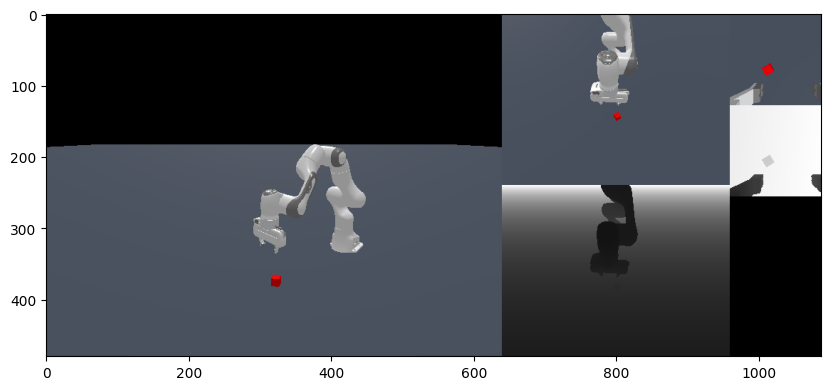

In [4]:
# Change resolutions
env = gym.make(
    "PickCube-v0",
    camera_cfgs=dict(base_camera=dict(width=320, height=240)),
    render_camera_cfgs=dict(width=640, height=480),
)
plot_img(env.render("cameras"))
env.close()
del env

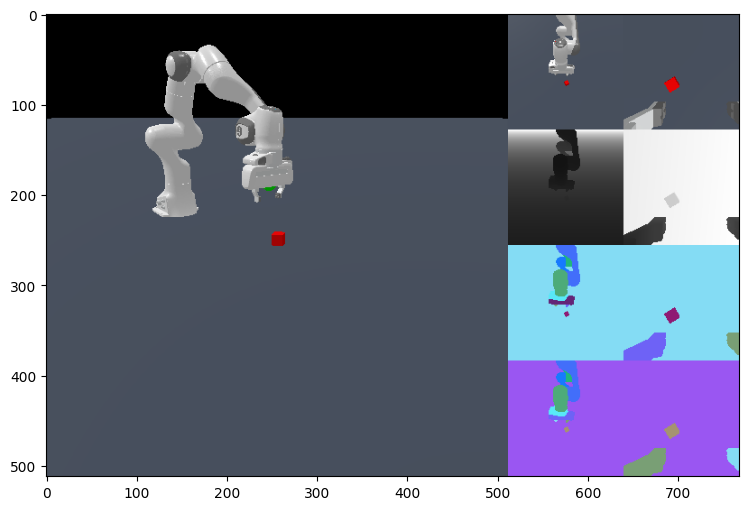

In [5]:
# Change poses and textures
from mani_skill2.utils.sapien_utils import look_at

pose = look_at([1, -1, 0.5], [0, 0, 0])
env = gym.make(
    "PickCube-v0",
    camera_cfgs=dict(texture_names=("Color", "Position", "Segmentation")),
    render_camera_cfgs=dict(p=pose.p, q=pose.q),
)
plot_img(env.render("cameras"))
env.close()
del env

`camera_cfgs` and `render_camera_cfgs` provide an ad-hoc way to configure cameras. To change default camera configurations, you can inherit the environment class and override `_register_cameras` and `_register_render_cameras`. Note that `_register_cameras` does not handle the cameras associated with the robot.

Moreover, to make custom environments you should use the `register_env` function as shown below so you can create them with `gym.make` later.

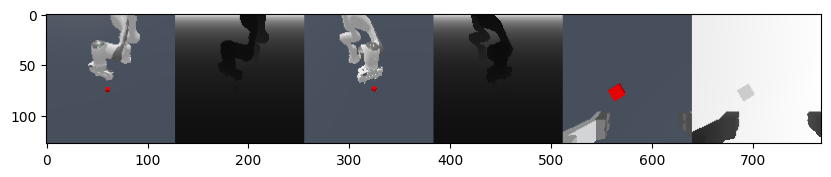

In [6]:
from mani_skill2.envs.pick_and_place.pick_cube import PickCubeEnv
from mani_skill2.sensors.camera import CameraConfig
from mani_skill2.utils.registration import register_env
from mani_skill2.utils.sapien_utils import look_at


@register_env("PickCube-MoreCamera-v0", max_episode_steps=200, override=True)
class PickCubeMoreCameraEnv(PickCubeEnv):
    def _register_cameras(self):
        pose = look_at([0.3, 0.2, 0.6], [-0.1, 0, 0.1])
        left_camera = CameraConfig(
            "left_camera", pose.p, pose.q, 128, 128, np.pi / 2, 0.01, 10
        )

        pose = look_at([0.3, -0.2, 0.6], [-0.1, 0, 0.1])
        right_camera = CameraConfig(
            "right_camera", pose.p, pose.q, 128, 128, np.pi / 2, 0.01, 10
        )
        return [left_camera, right_camera]
    
    def _register_render_cameras(self):
        return []


env = gym.make("PickCube-MoreCamera-v0")
plot_img(env.render("cameras"))
env.close()
del env

## Add dynamic objects and static scenes

In this section, we will showcase how to add dynamic objects and static scenes. As learning generalizable manipulation skills is already challenging, ManiSkill2 does not include widely-studied challenges like visual complexity by default. However, our design enables users to increase visual complexity in a pythonic, straightforward and flexible way.

In [ ]:
# Download YCB objects
!python -m mani_skill2.utils.download_asset ycb
# Download an example ReplicaCAD scene from Habitat
# You can use other dataset like Gibson or Matterport3D
!wget https://dl.fbaipublicfiles.com/habitat/ReplicaCAD/hab2_bench_assets.zip -P data
!cd data && unzip hab2_bench_assets.zip -q -d hab2_bench_assets

All the environments in ManiSkill2 follow the same pipeline to rest: 

```python
def reset(self, seed=None, reconfigure=False):
    ...
    if reconfigure:
        # Reconfigure the scene if assets change
        self.reconfigure()
    else:
        self._clear_sim_state()
    ...
    self.initialize_episode()
```

`reconfigure` reconfigures the simulation scene instance. The assets are only loaded during `reconfigure`.

```python
def reconfigure(self):
    """Reconfigure the simulation scene instance.
    This function should clear the previous scene, and create a new one.
    """
    self._clear()
    self._setup_scene()
    self._load_agent()  # Load the robot
    self._load_actors()  # Load rigid objects
    self._load_articulations()  # Load articulated objects
    self._setup_cameras()
    self._setup_lighting()
    ...
```

`initialize_episode` initializes each episode, and no assets are created.

```python
def initialize_episode(self):
    """Initialize the episode, e.g., poses of actors and articulations, and robot configuration.
    No new assets are created. Task-relevant information can be initialized here, like goals.
    """
    self._initialize_actors()
    self._initialize_articulations()
    self._initialize_agent()
    self._initialize_task()
```

However, it is not necessary to strictly follow the order of sub-routines defined in `initialize_episode`.
For example, you can initialize the poses in `_initialize_task`, as they can depend on task-relevant information.

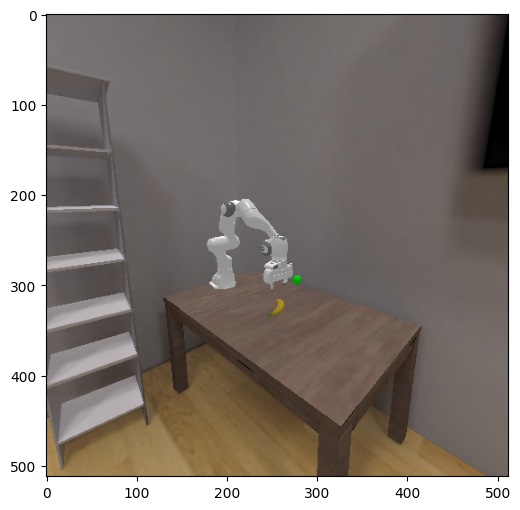

In [7]:
import sapien.core as sapien

from mani_skill2 import ASSET_DIR
from mani_skill2.envs.pick_and_place.pick_cube import PickCubeEnv
from mani_skill2.sensors.camera import CameraConfig
from mani_skill2.utils.registration import register_env
from mani_skill2.utils.sapien_utils import look_at


@register_env("PickYCBInReplicaCAD-v0", max_episode_steps=200, override=True)
class PickYCBInReplicaCAD(PickCubeEnv):
    def _load_actors(self):
        # Add ground and goal indicator as the super class
        self._add_ground()
        self.goal_site = self._build_sphere_site(self.goal_thresh)

        # Load YCB objects (the same as in PickSingleYCB-v0)
        builder = self._scene.create_actor_builder()
        model_dir = ASSET_DIR / "mani_skill2_ycb/models/011_banana"
        scale = self.cube_half_size / 0.01887479572529618
        collision_file = str(model_dir / "collision.obj")
        builder.add_multiple_collisions_from_file(
            filename=collision_file, scale=scale, density=1000
        )
        visual_file = str(model_dir / "textured.obj")
        builder.add_visual_from_file(filename=visual_file, scale=scale)
        self.obj = builder.build(name="apple")

        # Load static scene
        builder = self._scene.create_actor_builder()
        path = f"{ASSET_DIR}/hab2_bench_assets/stages/Baked_sc1_staging_00.glb"
        pose = sapien.Pose(q=[0.707, 0.707, 0, 0])
        # NOTE: use nonconvex collision for static scene
        builder.add_nonconvex_collision_from_file(path, pose)
        builder.add_visual_from_file(path, pose)
        self.arena = builder.build_static()

    def initialize_episode(self):
        super().initialize_episode()

        # Update poses so that the workspace is on the table
        offset = np.array([-2.0616, -3.1837, 0.66467 + 0.095])
        self.agent.robot.set_pose(
            sapien.Pose(offset + [0, -0.56, 0], [0.707, 0, 0, 0.707])
        )
        self.obj.set_pose(sapien.Pose(self.obj.pose.p + offset, self.obj.pose.q))
        self.goal_pos = self.goal_pos + offset + [0, 0.15, 0.0]
        self.goal_site.set_pose(sapien.Pose(self.goal_pos))

    def _register_render_cameras(self):
        cam_cfg = super()._register_render_cameras()
        cam_cfg.p = cam_cfg.p + [-2.0616, -3.1837, 0.66467]
        cam_cfg.fov = 1.5
        return cam_cfg


env = gym.make("PickYCBInReplicaCAD-v0")
plot_img(env.render("rgb_array"))
env.close()
del env


## Change the Robot

In this section, we will showcase how to customize the existing robot and add a new robot. In ManiSkill2, the agent is a collection of the robot, mounted cameras, and controllers.

### Customize the existing robot

We provide an agent implementation of Franka Emika, `Panda`, and different agent configurations in `mani_skill2.agents.configs.panda`.

In [8]:
from mani_skill2.agents.base_agent import AgentConfig

# The agent config should follow the signature, but is not required to inherit from AgentConfig
print(AgentConfig.__doc__)

Agent configuration.

    Args:
        urdf_path: path to URDF file. Support placeholders like {PACKAGE_ASSET_DIR}.
        urdf_config: a dict to specify materials and simulation parameters when loading URDF from SAPIEN.
        controllers: a dict of controller configurations
        cameras: a dict of onboard camera configurations
    


The next cell shows some ways to customize the robot, including changing materials, URDF, and controller. Importantly the robot configuration is also where you can customize mounted cameras.

More advanced examples can be found in `mani_skill2.agents.configs.panda.variants`


control_mode pd_joint_pos_new


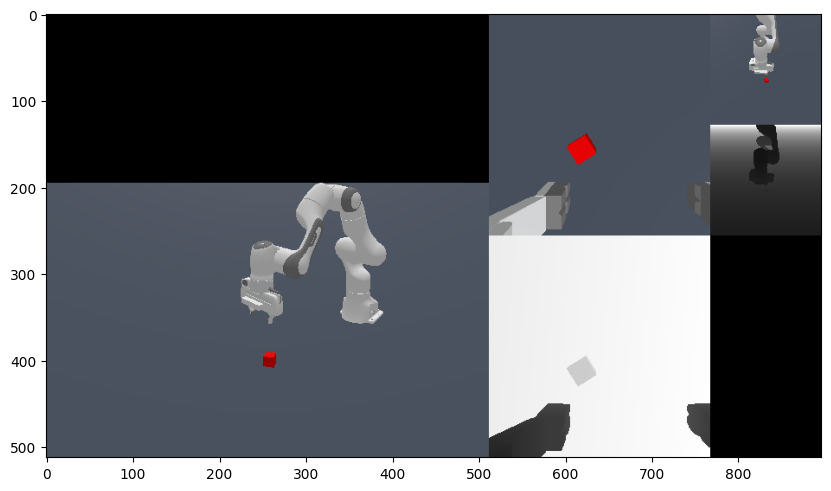

In [9]:
from copy import deepcopy
from mani_skill2.envs.pick_and_place.pick_cube import PickCubeEnv
from mani_skill2.utils.registration import register_env
from mani_skill2.utils.sapien_utils import get_entity_by_name

from mani_skill2.agents.base_agent import BaseAgent  # base class of other agents
from mani_skill2.agents.robots.panda import Panda
from mani_skill2.agents.configs.panda.defaults import PandaDefaultConfig
from mani_skill2.agents.controllers.pd_joint_pos import PDJointPosControllerConfig


class PandaCustomConfig(PandaDefaultConfig):
    def __init__(self):
        super().__init__()

        # Example: You can change the path to your customized URDF file
        # panda_v3 add a camera collision mounted on the hand
        self.urdf_path = "{PACKAGE_ASSET_DIR}/descriptions/panda_v3.urdf"

        # Example: change physical parameters (e.g., friction)
        # urdf_config will be parsed by `mani_skill2.utils.sapien_utils.parse_urdf_config`
        self.urdf_config["_materials"] = dict(
            gripper=dict(static_friction=5.0, dynamic_friction=5.0, restitution=0.0)
        )

    @property
    def controllers(self):
        controllers = super().controllers

        # Example: Change parameters of the existing controller
        arm_controller: PDJointPosControllerConfig = controllers["pd_joint_pos"]["arm"]
        arm_controller.stiffness = 500  # kp in PD controller

        # Example: Add a new controller
        new_arm_controller = deepcopy(arm_controller)
        new_gripper_controller = PDJointPosControllerConfig(
            self.gripper_joint_names,
            lower=0,
            upper=0.04,
            stiffness=500,
            damping=50,
            force_limit=100,
        )
        controllers["pd_joint_pos_new"] = dict(
            arm=new_arm_controller, gripper=new_gripper_controller
        )

        return controllers

    @property
    def cameras(self):
        # Example: Override the camera configuration (e.g., resolution and mounted actor)
        return CameraConfig(
            uid="hand_camera",
            p=[0, 0, 0],
            q=[1, 0, 0, 0],
            width=256,
            height=256,
            fov=1.57,
            near=0.01,
            far=10,
            actor_uid="camera_link",
        )


@register_env("PickCube-CustomPanda-v0", max_episode_steps=200, override=True)
class PickCubeCustomPandaEnv(PickCubeEnv):
    def _configure_agent(self):
        # This function will be called in __init__ so that the configurations of mounted cameras can be decided.
        self._agent_cfg = PandaCustomConfig()
        # You can also modify the agent configuration here in an ad-hoc way

    def _load_agent(self):
        self.agent = Panda(
            self._scene, self._control_freq, self._control_mode, config=self._agent_cfg
        )
        self.tcp: sapien.Link = get_entity_by_name(
            self.agent.robot.get_links(), self.agent.config.ee_link_name
        )


env = gym.make("PickCube-CustomPanda-v0", control_mode="pd_joint_pos_new")
print("control_mode", env.control_mode)
plot_img(env.render("cameras"))
env.close()
del env

### Add a new robot

Adding a new robot in ManiSkill2 includes several aspects:
- Download or create URDF and assets (usually from the ROS package).  
- Implement an agent class inherited from `BaseAgent`
- Implement agent configurations (controllers, cameras, ...)
- Support the new agent class in the environment

We refer readers to our implementation of Xmate3 as an example. The environments in `mani_skill2.envs.pick_and_place` all support Xmate3.

```python
from mani_skill2.agents.robots.xmate3 import Xmate3Robotiq
from mani_skill2.agents.configs.xmate3.defaults import Xmate3RobotiqDefaultConfig
```

In [ ]:
from mani_skill2 import ASSET_DIR
from mani_skill2.utils.download_asset import download

download(
    "https://storage1.ucsd.edu/datasets/ManiSkill2022-assets/xmate3_robotiq.zip",
    output_dir=ASSET_DIR,
    target_path="xmate3_robotiq",
)

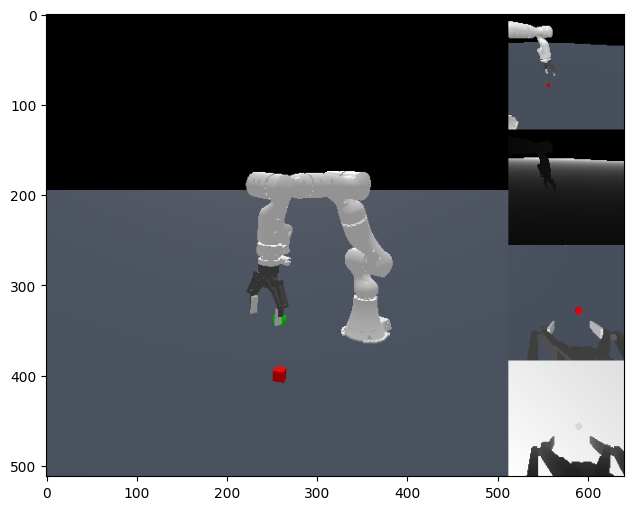

In [10]:
env = gym.make("PickCube-v0", robot="xmate3_robotiq")
plot_img(env.render("cameras"))
env.close()
del env

## Domain randomization

In this section, we will showcase how to add domain randomization (e.g., visual appearance, physical parameters).

First, we show how we randomize physical parameters and visual apperance, which can be applied without reconfiguring the simulation scene. 

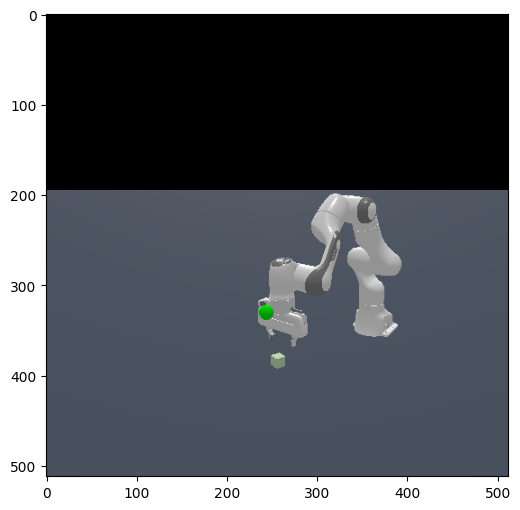

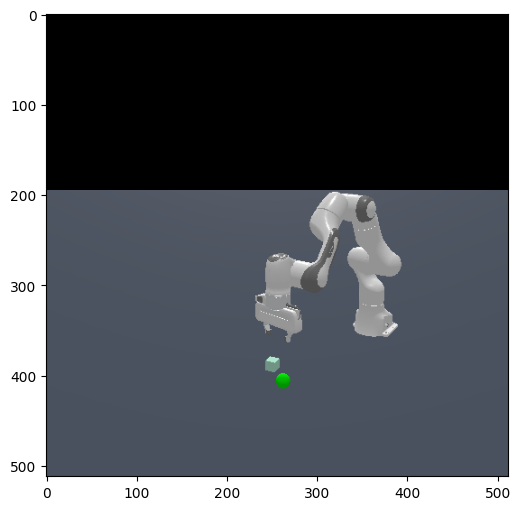

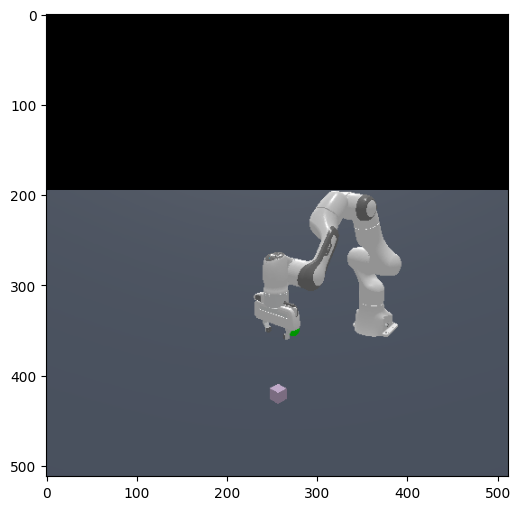

In [11]:
import sapien.core as sapien

from mani_skill2.envs.pick_and_place.pick_cube import PickCubeEnv
from mani_skill2.utils.registration import register_env
from mani_skill2.utils.sapien_utils import set_render_material


@register_env("DR-PickCube-v0", max_episode_steps=100, override=True)
class DomainRandomizationPickCubeEnv(PickCubeEnv):
    def _initialize_actors(self):
        super()._initialize_actors()

        # Example: randomize friction
        friction = self._episode_rng.uniform(0.5, 1.0)
        phys_mtl = self._scene.create_physical_material(
            static_friction=friction, dynamic_friction=friction, restitution=0.1
        )
        for cs in self.obj.get_collision_shapes():
            cs.set_physical_material(phys_mtl)

        # Example: randomize damping
        linear_damping = self._episode_rng.uniform(0, 1.0)
        angular_damping = self._episode_rng.uniform(0, 1.0)
        self.obj.set_damping(linear_damping, angular_damping)

        # Example: randomize color
        color = self._episode_rng.uniform(0.5, 1.0, size=3)
        for vb in self.obj.get_visual_bodies():
            for rs in vb.get_render_shapes():
                set_render_material(rs.material, color=np.hstack([color, 1.0]))


env = gym.make("DR-PickCube-v0")
for _ in range(3):
    env.reset()
    plot_img(env.render("rgb_array"))
env.close()
del env


Next, we show how to randomize object properties, which require reconfiguring the simulation scene.

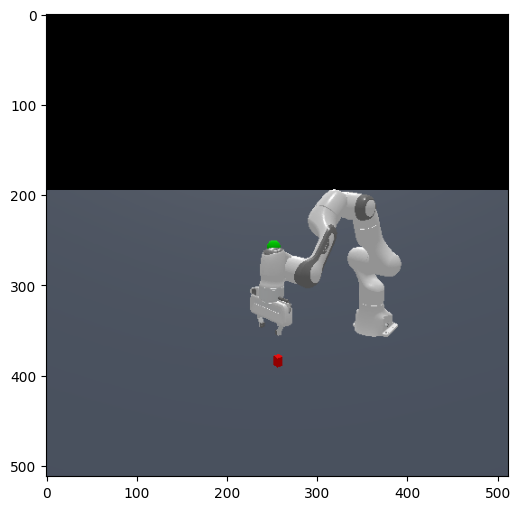

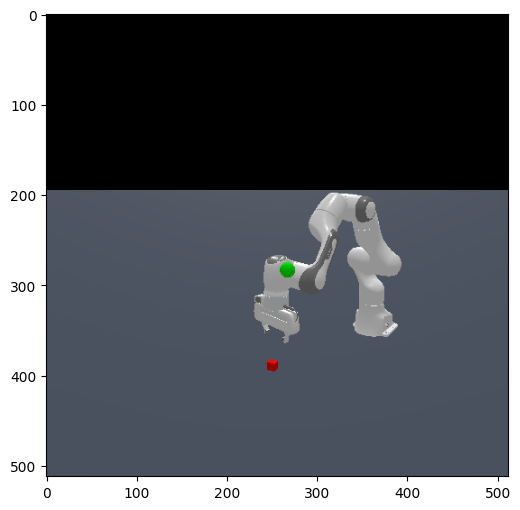

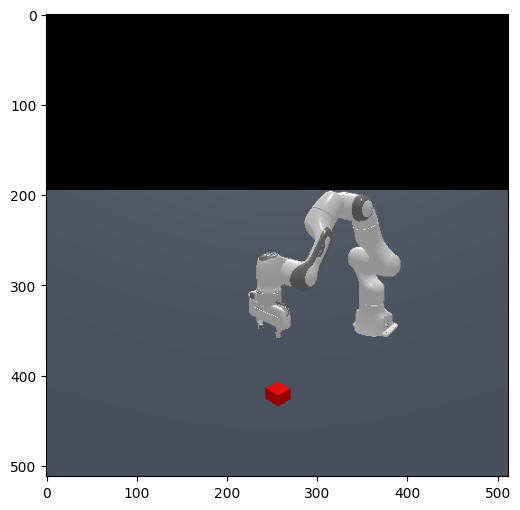

In [12]:
import sapien.core as sapien

from mani_skill2.envs.pick_and_place.pick_cube import PickCubeEnv
from mani_skill2.utils.registration import register_env


@register_env("DR-PickCube-v1", max_episode_steps=100, override=True)
class DomainRandomizationPickCubeEnvV1(PickCubeEnv):
    # Reconfigure the environment when reset by default
    def reset(self, seed=None, reconfigure=True):
        return super().reset(seed, reconfigure)

    def _load_actors(self):
        self.cube_half_size = self._episode_rng.uniform(0.01, 0.03, size=3)
        super()._load_actors()


env = gym.make("DR-PickCube-v1")
for _ in range(3):
    env.reset()
    plot_img(env.render("rgb_array"))
env.close()
del env

## Adjust lighting

You can enable shadows to improve photorealism as shown below

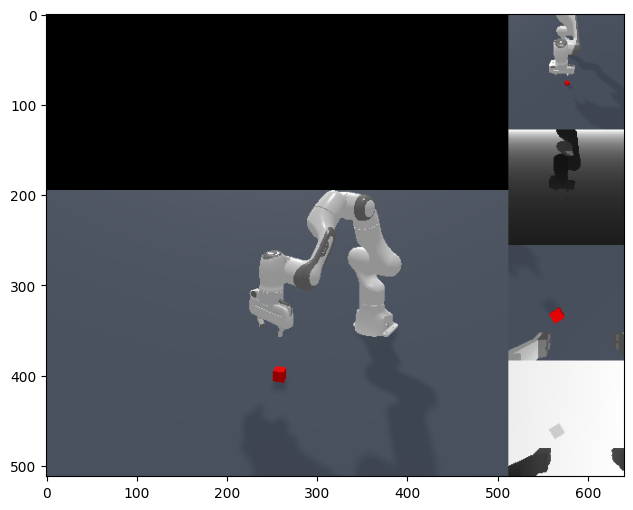

In [13]:
env = gym.make("PickCube-v0", enable_shadow=True)
plot_img(env.render("cameras"))
env.close()
del env

You can override `_setup_lighting` to modify lighting directly as well

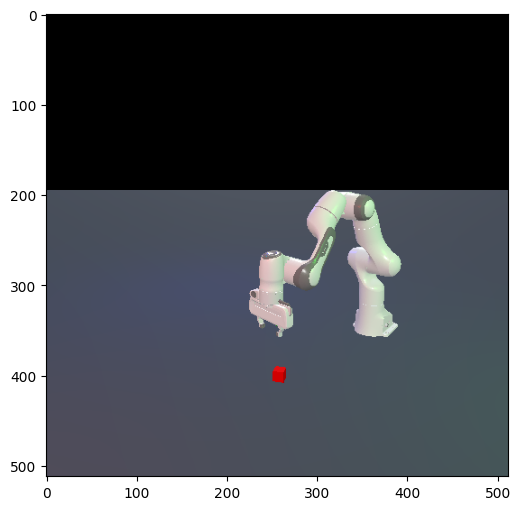

In [14]:
from mani_skill2.envs.pick_and_place.pick_cube import PickCubeEnv
from mani_skill2.utils.registration import register_env


@register_env("PickCube-Light-v0", max_episode_steps=100, override=True)
class PickCubeLightEnv(PickCubeEnv):
    def _setup_lighting(self):
        shadow = self.enable_shadow
        self._scene.set_ambient_light([0.3, 0.3, 0.3])
        # Only the first of directional lights can have shadow
        self._scene.add_directional_light(
            [1, 1, -1], [1, 1, 1], shadow=shadow, scale=5, shadow_map_size=2048
        )
        self._scene.add_directional_light([-1, -1, -1], [1, 1, 1])
        self._scene.add_point_light([1, 0, 1], [1, 0, 0], shadow=shadow)
        self._scene.add_point_light([-0.5, 1, 1], [0, 1, 0], shadow=shadow)
        self._scene.add_point_light([-0.5, -1, 1], [0, 0, 1], shadow=shadow)


env = gym.make("PickCube-Light-v0")
plot_img(env.render("rgb_array"))
env.close()
del env